In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import temperaturemodels as tempmod
from scipy.integrate import solve_ivp

In [2]:
K0 = 273.15
R = 8.314472 # gas constant

In [3]:
### base parameter set
pbase = dict(a=.2,b=.8,K=30,n=10,ap=0.1,bp=0.4,Kp=30,m=5,ks=1.25,bdeg=0.1, app=0.1, bpp=0.9, Kpp=30, l=15, epsilon=1)
udeg = 0 # no degradation in u variable
theta = 0.3 # to compute up down times

T0 = 18 + K0 # reference temperature

## things we want to keep
alldurations = ['interphase','mitosis','up','down','rising','falling', 'total']


def simulate_temperatures(params, Tvals, pbase=pbase):
    # simulates the model over a range of temperatures given by Tvals (in Kelvin)
    # params defines the scalings of ks, bdeg and epsilon
    # this function returns a dictionary
    # the keys are interphase, mitosis, up, down, rising, falling, total
    # the values are arrays with the durations of these phases at each temperature in Tvals
    
    # Note: we could compute everything with the variable u or with the variable v
    # u is Cdk, which would correspond to the data from the extract (FRET sensor)
    
    b1_ks,b2_ks=tempmod.getb1b2(params['E1_ks'],params['E2_ks'],params['ks0'],T0,params['Tm_ks'])
    def ksT(T):
        return (np.exp(b1_ks + params['E1_ks']/R/T)+np.exp(b2_ks+params['E2_ks']/R/T))**(-1)

    b1_bdeg,b2_bdeg=tempmod.getb1b2(params['E1_bdeg'],params['E2_bdeg'],params['bdeg0'],T0,params['Tm_bdeg'])
    def bdegT(T):
        return (np.exp(b1_bdeg + params['E1_bdeg']/R/T)+np.exp(b2_bdeg+params['E2_bdeg']/R/T))**(-1)
        
    # attention: epsilon is not a rate but inverse of a rate
    b1_epsilon,b2_epsilon=tempmod.getb1b2(params['E1_epsilon'],params['E2_epsilon'],1/params['epsilon0'],T0,params['Tm_epsilon'])
    def epsilonT(T):
        return (np.exp(b1_epsilon + params['E1_epsilon']/R/T)+np.exp(b2_epsilon+params['E2_epsilon']/R/T))**(1)
    
    res = {d: np.zeros(len(Tvals)) for d in alldurations}
    
    for i,T in enumerate(Tvals):
        pp = pbase.copy()
        pp['ks'] =  ksT(T)
        pp['bdeg'] = bdegT(T)
        pp['epsilon'] = epsilonT(T)

        M = tempmod.BistableModelYF(**pp)
        M.solve(1000, 0.1, y0=(0.1, 0.1),udeg=udeg)
        # save the last period
        M.getperiod(method='robust', thr=0.01)
        M.getfinalperiodtimeseries()

        if M.period !=0 :
            # this means it is oscillating. We compute all different measures. 
            uv = M.u0v
            # shift such that we start from the maximum
            uv = np.roll(uv, -np.argmax(uv))
            tv = M.t0v-M.t0v[0]
            
            cdk_s = uv
            tv_s = tv # just because these names were used in the code I copied from
            
            #### now compute all the duration timings
            total = tv_s[-1]-tv_s[0]
            # rising and falling
            imin = np.argmin(cdk_s)
            falling = tv_s[imin]-tv_s[0] # beginning to minimum
            rising = total-falling
            
            # then compute for four parts (interphase, mitosis, up, down)
            # first determine thresholds. Theta is given above
            try:
                cdk_low = np.min(cdk_s)
                cdk_high = np.max(cdk_s)
                amp = cdk_high-cdk_low

                thr_lo = cdk_low + theta*amp
                thr_hi = cdk_low + (1-theta)*amp
                
                
                # define crossing points of the thresholds
                # look at the down part
                id1 = np.nonzero(cdk_s<thr_hi)[0][0]
                id2 = np.nonzero(cdk_s<thr_lo)[0][0]

                # start at minimum to look at the up part
                shift = np.argmin(cdk_s)
                cdk_s = np.roll(cdk_s, -shift)

                iu1 = np.nonzero(cdk_s>thr_lo)[0][0]+shift
                iu2 = np.nonzero(cdk_s>thr_hi)[0][0]+shift
                
                if id1>=len(tv) or id2>=len(tv) or iu1>=len(tv) or iu2>=len(tv):
                    up=down=interphase=mitosis=np.nan
                else:
                    up = tv[iu2]-tv[iu1]
                    down = tv[id2]-tv[id1]
                    interphase = tv[iu1]-tv[id2]
                    mitosis = total - up - down-interphase
            except IndexError:
                print(len(tv), id1, id2, iu1, iu2)
                
            
            res['interphase'][i] = interphase
            res['mitosis'][i] = mitosis
            res['up'][i] = up
            res['down'][i] = down
            res['rising'][i] = rising
            res['falling'][i] = falling
            res['total'][i] = total
        else:
            for d in alldurations:
                res[d][i] = np.nan

    return res


In [4]:
params_abc = pd.read_csv("results_ABC_extract_0100_t35.csv")

In [5]:
## test
ind_min = params_abc['distance'].argmin() # index of parameter set that gave smallest distance to data. Can also use another sample/param set
params = params_abc.iloc[ind_min,:-2].to_dict() # Drop last two columns (weight, distances)

print(params)
Tvals = np.arange(10, 40)+K0
# simulate
res = simulate_temperatures(params, Tvals)

{'E1_bdeg': 34994.67424647078, 'E1_epsilon': 79845.90371235608, 'E1_ks': 123288.92183194164, 'E2_bdeg': -15090.188486099418, 'E2_epsilon': -111363.50460770538, 'E2_ks': -73536.50607245055, 'Tm_bdeg': 298.0158780923504, 'Tm_epsilon': 307.54807015392464, 'Tm_ks': 297.3959542475006, 'bdeg0': 0.134242237610113, 'epsilon0': 15.683092034112583, 'ks0': 1.2275646649112038}


Text(0, 0.5, 'Period (minutes)')

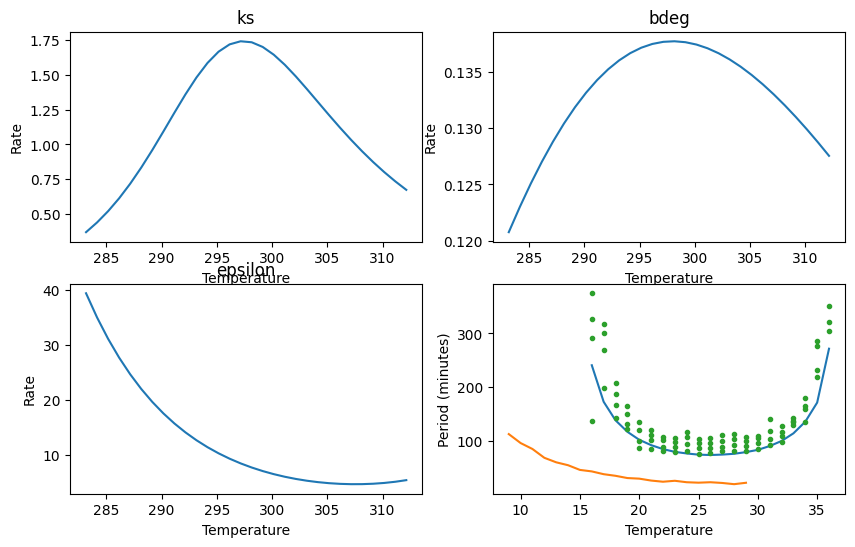

In [6]:
data_extract = pd.read_csv("extract_data_selected.csv")
data_embryo = pd.read_csv("data_laevis_onlyavg.csv")
### plot the results

## plot scaling of parameters as well as the period
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

b1_ks,b2_ks=tempmod.getb1b2(params['E1_ks'],params['E2_ks'],params['ks0'],T0,params['Tm_ks'])
def ksT(T):
    return (np.exp(b1_ks + params['E1_ks']/R/T)+np.exp(b2_ks+params['E2_ks']/R/T))**(-1)

b1_bdeg,b2_bdeg=tempmod.getb1b2(params['E1_bdeg'],params['E2_bdeg'],params['bdeg0'],T0,params['Tm_bdeg'])
def bdegT(T):
    return (np.exp(b1_bdeg + params['E1_bdeg']/R/T)+np.exp(b2_bdeg+params['E2_bdeg']/R/T))**(-1)
    
# attention: epsilon is not a rate but inverse of a rate
b1_epsilon,b2_epsilon=tempmod.getb1b2(params['E1_epsilon'],params['E2_epsilon'],1/params['epsilon0'],T0,params['Tm_epsilon'])
def epsilonT(T):
    return (np.exp(b1_epsilon + params['E1_epsilon']/R/T)+np.exp(b2_epsilon+params['E2_epsilon']/R/T))**(1)

axes[0,0].plot(Tvals, ksT(Tvals)) 
axes[0,0].set_title('ks')
axes[0,1].plot(Tvals, bdegT(Tvals)) 
axes[0,1].set_title('bdeg')
axes[1,0].plot(Tvals, epsilonT(Tvals)) 
axes[1,0].set_title('epsilon')

### period
axes[1,1].plot(Tvals-K0, res['total'])
## add data
axes[1,1].plot(data_embryo['T'], data_embryo['avg'])
axes[1,1].plot(data_extract['Temperature_r'], data_extract['Totalmean'], '.')

for ax in axes.flatten():
    ax.set_xlabel("Temperature")
for ax in axes.flatten()[:3]:
    ax.set_ylabel("Rate")
axes[1,1].set_ylabel("Period (minutes)")

In [7]:
pbase = dict(a=.2,b=.8,K=30,n=10,ap=0.1,bp=0.4,Kp=30,m=5,ks=1.25,bdeg=0.1, app=0.1, bpp=0.9, Kpp=30, l=15, epsilon=1)
ind_min = params_abc['distance'].argmin()
Tvals = np.linspace(10, 40, 60) + K0
kifactor_values = [0.6, 0.7, 0.8, 0.9, 1.1, 1.4]

result = {}

for kifactor in kifactor_values:
    print(f"Simulating {kifactor}")
    params = params_abc.iloc[ind_min,:-2].to_dict()
    params['ks0'] = pbase['ks']*kifactor
    res = simulate_temperatures(params, Tvals, pbase=pbase)
    result[f"{kifactor}"] = {
        'temp': Tvals - K0,
        'period': res['total']
    }

Simulating 0.6
Simulating 0.7
Simulating 0.8
Simulating 0.9
Simulating 1.1
Simulating 1.4


In [32]:
save_path = "E:/Thesis/Chapter 4 - Temperature/"

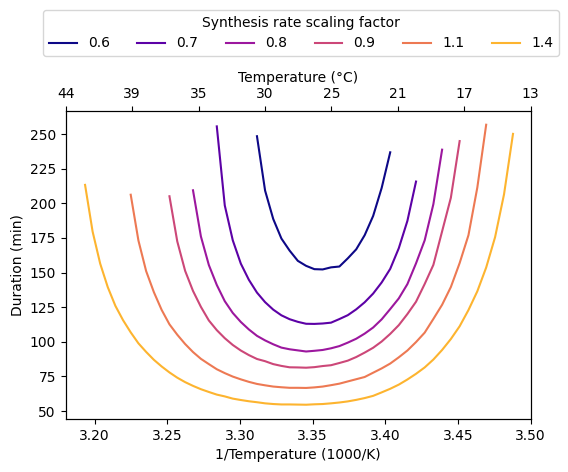

In [34]:
cmap = plt.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(6, 4))
for idx, key in enumerate(result.keys()):
    temp = result[key]['temp']
    period = result[key]['period']
    relative_temp = 1000 / (temp + K0)
    # remove all nans
    mask = np.logical_not(np.isnan(period))
    period = period[mask]
    relative_temp = relative_temp[mask]
    color = cmap(idx / len(kifactor_values))
    ax.plot(relative_temp, period, label=key,
            color=color)
    # Add an axis at the top with the temp

ax.set_xlim([3.18, 3.5])
ax2 = ax.twiny()
xticks = ax.get_xticks()
new_labels = [f"{1000/t - K0:.0f}" for t in xticks]
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels(new_labels)
ax2.set_xlabel("Temperature (°C)")

ax.set_xlabel('1/Temperature (1000/K)')
ax.set_ylabel("Duration (min)")
ax.legend(title="Synthesis rate scaling factor", ncols=6,
          bbox_to_anchor=(1.075, 1.35))
fig_save_path = save_path + "morpholino_simulation.pdf"
fig.savefig(fig_save_path, bbox_inches='tight')
plt.show()